In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

cohorts = ['PRJNA190055', 'PRJNA392762', 'PRJNA540064', 'PRJNA541075', 'PRJNA544721', 
           'PRJNA579180', 'PRJNA604466', 'PRJNA633542', 'PRJNA644520', 'PRJNA789106', 
           'PRJNA812699', 'PRJNA1001944']
taxonomy_levels = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

def load_data(cohort, taxonomy):
    """Load a CSV file for a given cohort and taxonomy level."""
    try:
        filename = f"../../dataset/IBS_pivoted/{cohort}_{taxonomy}_pivoted.csv"
        df = pd.read_csv(filename)
        features = df.columns[1:]  
        return set(features)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return set()

cohort_features = defaultdict(dict) 
feature_presence_count = defaultdict(Counter) 

for taxonomy in taxonomy_levels:
    for cohort in cohorts:
        features = load_data(cohort, taxonomy)
        if features:
            cohort_features[taxonomy][cohort] = features
            for feature in features:
                feature_presence_count[taxonomy][feature] += 1

results = pd.DataFrame(index=taxonomy_levels)
for i in range(1, len(cohorts) + 1):
    counts = []
    for taxonomy in taxonomy_levels:
        count = sum(1 for _, presence in feature_presence_count[taxonomy].items() if presence >= i)
        counts.append(count)
    results[f"≥{i} cohorts"] = counts

totals = []
for taxonomy in taxonomy_levels:
    totals.append(len(feature_presence_count[taxonomy]))
results['Total Features'] = totals

print("Number of Features Present in At Least X Cohorts by Taxonomy Level")
print("=" * 100)
print(results)
print("\n")
print("Top Contributing Cohorts by Threshold")
print("=" * 100)

for i in range(1, len(cohorts) + 1):
    print(f"\nFor features present in ≥{i} cohorts:")
    num_top_cohorts = min(i, len(cohorts))
    for taxonomy in taxonomy_levels:
        common_features = [feature for feature, count in feature_presence_count[taxonomy].items() if count >= i]
        if not common_features:
            print(f"  {taxonomy}: No features present in ≥{i} cohorts")
            continue
        cohort_contribution = {}
        for cohort in cohorts:
            if cohort in cohort_features[taxonomy]:
                contribution = len(set(common_features) & cohort_features[taxonomy][cohort])
                contribution_percentage = (contribution / len(common_features)) * 100
                cohort_contribution[cohort] = (contribution, contribution_percentage)
        
        sorted_contributions = sorted(
            cohort_contribution.items(), 
            key=lambda x: x[1][0], 
            reverse=True
        )
        top_cohorts = sorted_contributions[:num_top_cohorts]
        print(f"  {taxonomy} (total {len(common_features)} features):")
        for rank, (cohort, (count, percentage)) in enumerate(top_cohorts, 1):
            print(f"    {rank}. {cohort}: {count}/{len(common_features)} features ({percentage:.1f}%)")

print("\n\nCollective Coverage by Top Cohorts")
print("=" * 100)

for i in range(1, len(cohorts) + 1):
    print(f"\nFor features present in ≥{i} cohorts:")
    num_top_cohorts = min(i, len(cohorts))
    for taxonomy in taxonomy_levels:
        common_features = [feature for feature, count in feature_presence_count[taxonomy].items() if count >= i]
        if not common_features:
            print(f"  {taxonomy}: No features present in ≥{i} cohorts")
            continue
        cohort_contribution = {}
        for cohort in cohorts:
            if cohort in cohort_features[taxonomy]:
                contribution = len(set(common_features) & cohort_features[taxonomy][cohort])
                cohort_contribution[cohort] = (contribution, set(common_features) & cohort_features[taxonomy][cohort])
        sorted_cohorts = sorted(
            cohort_contribution.items(), 
            key=lambda x: x[1][0], 
            reverse=True
        )
        top_cohorts = sorted_cohorts[:num_top_cohorts]
        all_covered_features = set()
        for cohort, (_, features) in top_cohorts:
            all_covered_features.update(features)
        collective_coverage = len(all_covered_features)
        coverage_percentage = (collective_coverage / len(common_features)) * 100
        print(f"  {taxonomy}: Top {num_top_cohorts} cohorts collectively cover {collective_coverage}/{len(common_features)} features ({coverage_percentage:.1f}%)")
        cohort_names = [cohort for cohort, _ in top_cohorts]
        print(f"    Top cohorts: {', '.join(cohort_names)}")

Number of Features Present in At Least X Cohorts by Taxonomy Level
         ≥1 cohorts  ≥2 cohorts  ≥3 cohorts  ≥4 cohorts  ≥5 cohorts  \
kingdom          11          11           4           4           4   
phylum          114          57          29          21          15   
class           196         121          58          33          25   
order           421         297         141          67          46   
family          913         635         239         114          76   
genus          3783        2436         603         192          76   
species       15002        6159        1017         184          32   

         ≥6 cohorts  ≥7 cohorts  ≥8 cohorts  ≥9 cohorts  ≥10 cohorts  \
kingdom           3           3           3           3            2   
phylum           10           9           7           6            5   
class            23          18          14          11            6   
order            31          27          18          10            6   
fami

: 

### Analyse Genus >= 4 cohorts first
### Then maybe as a backup uses family >= 4 cohorts

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import evaluate_global_shap_scores
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)


selected_cohorts = ['PRJNA812699', 'PRJNA1001944', 'PRJNA789106', 'PRJNA579180']
taxonomy_level = 'genus'

def load_and_process_cohort_data(cohort, taxonomy_level):
    """Load data for a given cohort and taxonomy level, and return processed dataframe."""
    try:
        filename = f"../../dataset/IBS_pivoted/{cohort}_{taxonomy_level}_pivoted.csv"
        df = pd.read_csv(filename)
        feature_cols = [col for col in df.columns if col not in ['id', 'class']]
        df['cohort'] = cohort
        return df, set(feature_cols)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, set()

all_dfs = []
all_features = []

for cohort in selected_cohorts:
    df, features = load_and_process_cohort_data(cohort, taxonomy_level)
    if df is not None:
        all_dfs.append(df)
        all_features.append(features)

common_features = set.intersection(*all_features)
print(f"Number of common {taxonomy_level} features across all 4 cohorts: {len(common_features)}")

combined_df = pd.DataFrame()

# for i, df in enumerate(all_dfs):
#     cohort_df = df[['acc', 'class', 'cohort'] + [f for f in common_features if f in df.columns]]
#     for feature in common_features:
#         if feature not in df.columns:
#             cohort_df[feature] = 0
#     if i == 0:
#         combined_df = cohort_df
#     else:
#         combined_df = pd.concat([combined_df, cohort_df], ignore_index=True)


for i, df in enumerate(all_dfs):
    # Only keep common features that actually exist in this dataframe
    available_common_features = [f for f in common_features if f in df.columns]
    cohort_df = df[['acc', 'class', 'cohort'] + available_common_features]
    
    if i == 0:
        combined_df = cohort_df
    else:
        combined_df = pd.concat([combined_df, cohort_df], ignore_index=True)

Number of common genus features across all 4 cohorts: 116


In [7]:
len_combined_df = combined_df.count(axis=1)
print(f"Number of samples in combined dataframe: {len(len_combined_df)}")

Number of samples in combined dataframe: 1334


In [16]:
causal_shap_results = {
    'Lactobacillus': 0.06925,
    'Gemella': 0.02589,
    'Tyzzerella': 0.02136,
    'Anaerobutyricum': 0.01150,
    'Fusicatenibacter': 0.01068,
    'Porphyromonas': 0.00543,
    'Faecalibacterium': 0.00479,
    'Dorea': 0.00472,
    'Odoribacter': 0.00234,
    'Leptotrichia': 0.00186
}

# Calculate mean bacteria counts for Control and IBS groups
def calculate_group_means(df, bacteria_list, class_column='class'):
    """Calculate mean bacteria counts for each group (Control vs IBS)"""
    results = []
    
    for bacteria in bacteria_list:
        if bacteria in df.columns:
            # Calculate means for each group
            control_mean = df[df[class_column] == 0][bacteria].mean()
            ibs_mean = df[df[class_column] == 1][bacteria].mean()
            
            results.append({
                'Bacteria': bacteria,
                'Causal_SHAP_Importance': causal_shap_results[bacteria],
                'Average_Count_Control': control_mean,
                'Average_Count_IBS': ibs_mean
            })
        else:
            print(f"Warning: {bacteria} not found in the dataset")
            results.append({
                'Bacteria': bacteria,
                'Causal_SHAP_Importance': causal_shap_results[bacteria],
                'Average_Count_Control': np.nan,
                'Average_Count_IBS': np.nan
            })
    
    return pd.DataFrame(results)

bacteria_list = list(causal_shap_results.keys())
expanded_table = calculate_group_means(combined_df, bacteria_list)
print(expanded_table)


           Bacteria  Causal_SHAP_Importance  Average_Count_Control  \
0     Lactobacillus                 0.06925            1225.704787   
1           Gemella                 0.02589             130.465426   
2        Tyzzerella                 0.02136             233.303191   
3   Anaerobutyricum                 0.01150           10910.978723   
4  Fusicatenibacter                 0.01068            3870.101064   
5     Porphyromonas                 0.00543             103.390957   
6  Faecalibacterium                 0.00479           49409.880319   
7             Dorea                 0.00472            4817.640957   
8       Odoribacter                 0.00234           10259.117021   
9      Leptotrichia                 0.00186              16.425532   

   Average_Count_IBS  
0         874.327766  
1          85.088727  
2         182.008351  
3        7637.815240  
4        3321.514614  
5         101.310021  
6       51972.077244  
7        3864.210856  
8        7240.399791  

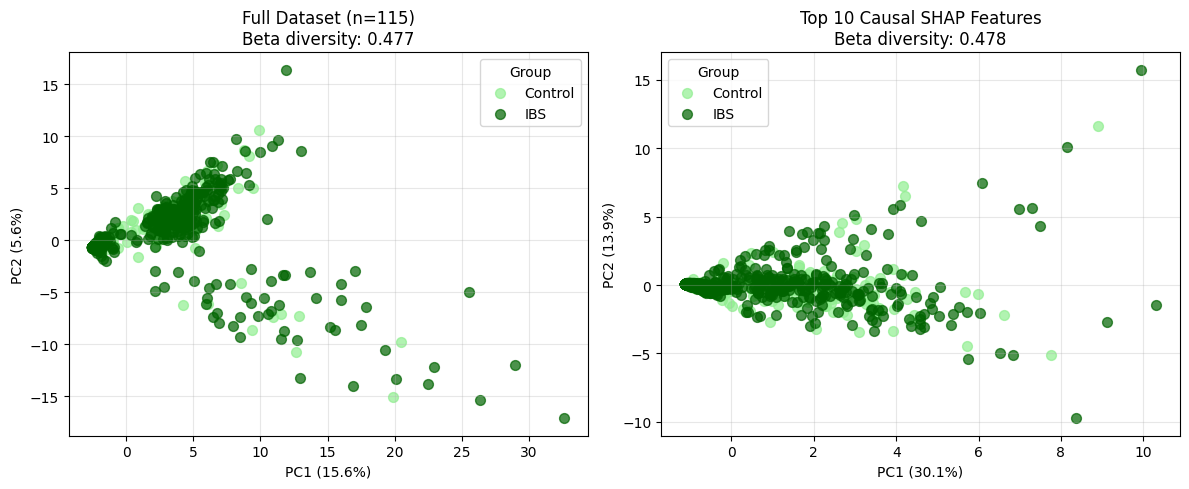

Unique values in y_full: [0 1]
Unique values in y_top10: [0 1]
Sample counts - Full: Control=376, IBS=958
Sample counts - Top10: Control=376, IBS=958
Beta diversity improvement: -0.4%
Variance explained - Full: 21.1%
Variance explained - Top 10: 44.0%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Top 10 bacteria from Causal SHAP
top_bacteria = list(causal_shap_results.keys())

# Prepare data
def prepare_pca_data(df, features, class_col='class'):
    available_features = [col for col in features if col in df.columns]
    data = df[available_features + [class_col]].dropna()
    
    X = data[available_features]
    y = data[class_col]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

# Calculate Beta diversity
def calc_beta_diversity(X):
    X_rel = X / (X.sum(axis=1, keepdims=True) + 1e-10)
    distances = pairwise_distances(X_rel, metric='braycurtis')
    return np.mean(distances[np.triu_indices_from(distances, k=1)])

# Get all bacterial columns
all_bacteria = [col for col in combined_df.columns if col not in ['acc', 'class', 'cohort']]

# Prepare datasets
X_full, y_full = prepare_pca_data(combined_df, all_bacteria)
X_top10, y_top10 = prepare_pca_data(combined_df, top_bacteria)

# PCA
pca_full = PCA(n_components=2)
pca_top10 = PCA(n_components=2)

X_pca_full = pca_full.fit_transform(X_full)
X_pca_top10 = pca_top10.fit_transform(X_top10)

# Calculate beta diversity
beta_full = calc_beta_diversity(X_full)
beta_top10 = calc_beta_diversity(X_top10)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Define colors and labels for numeric values
colors = {0: '#90EE90', 1: '#006400'}  # 0=Control, 1=IBS
labels = {0: 'Control', 1: 'IBS'}

# Full dataset plot
for group in [0, 1]:
    mask = y_full == group
    if mask.sum() > 0:  # Only plot if group exists
        ax1.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1], 
                   c=colors[group], label=labels[group], alpha=0.7, s=50)

ax1.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%})')
ax1.set_title(f'Full Dataset (n={len(all_bacteria)})\nBeta diversity: {beta_full:.3f}')
ax1.legend(title='Group')
ax1.grid(True, alpha=0.3)

# Top 10 plot
for group in [0, 1]:
    mask = y_top10 == group
    if mask.sum() > 0:  # Only plot if group exists
        ax2.scatter(X_pca_top10[mask, 0], X_pca_top10[mask, 1], 
                   c=colors[group], label=labels[group], alpha=0.7, s=50)

ax2.set_xlabel(f'PC1 ({pca_top10.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_top10.explained_variance_ratio_[1]:.1%})')
ax2.set_title(f'Top 10 Causal SHAP Features\nBeta diversity: {beta_top10:.3f}')
ax2.legend(title='Group')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Debug info
print(f"Unique values in y_full: {np.unique(y_full)}")
print(f"Unique values in y_top10: {np.unique(y_top10)}")
print(f"Sample counts - Full: Control={sum(y_full==0)}, IBS={sum(y_full==1)}")
print(f"Sample counts - Top10: Control={sum(y_top10==0)}, IBS={sum(y_top10==1)}")

# Print results
print(f"Beta diversity improvement: {((beta_full - beta_top10)/beta_full*100):.1f}%")
print(f"Variance explained - Full: {sum(pca_full.explained_variance_ratio_):.1%}")
print(f"Variance explained - Top 10: {sum(pca_top10.explained_variance_ratio_):.1%}")

Running t-SNE (this may take a minute)...


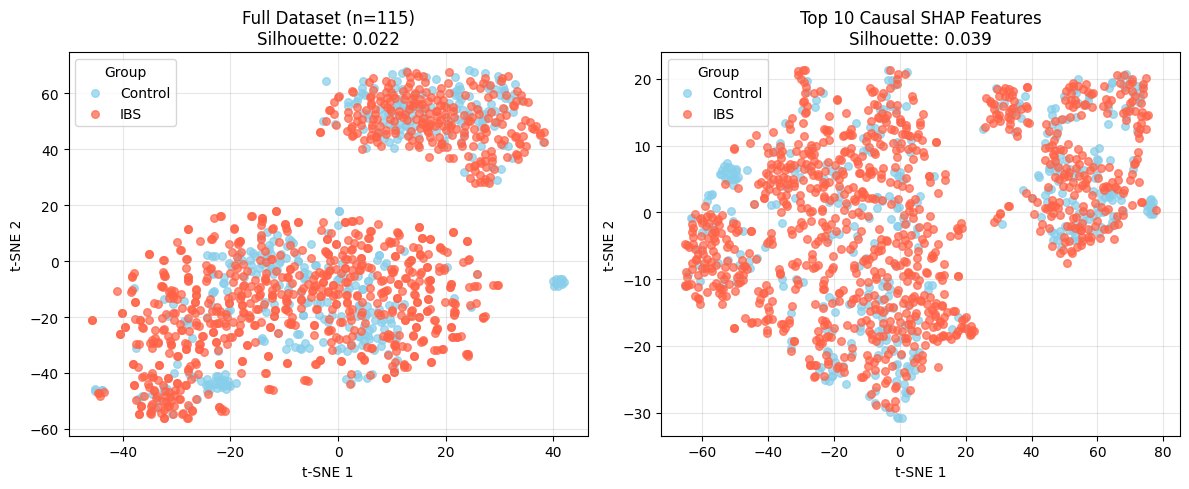


Results:
Full dataset silhouette: 0.022
Top 10 features silhouette: 0.039
Improvement: 78.7%
✗ Still no clear improvement in separation


Loading and processing cohort data...
Number of common genus features across all cohorts: 116

INDIVIDUAL DATASET PERFORMANCE

Evaluating PRJNA812699...
Dataset size: 1,184 samples
  • IBS cases: 834 (70.4%)
  • Control cases: 350 (29.6%)
Test set: 356 samples (IBS: 251, Control: 105)
Performance Metrics:
  • Accuracy: 0.716
  • Sensitivity: 0.916
  • Specificity: 0.238
  • Precision: 0.683
  • F1-Score: 0.676
  • AUC-ROC: 0.738
Confusion Matrix: TP=230, TN=25, FP=80, FN=21

Evaluating PRJNA1001944...
Dataset size: 59 samples
  • IBS cases: 49 (83.1%)
  • Control cases: 10 (16.9%)
Test set: 18 samples (IBS: 15, Control: 3)
Performance Metrics:
  • Accuracy: 0.833
  • Sensitivity: 1.000
  • Specificity: 0.000
  • Precision: 0.694
  • F1-Score: 0.758
  • AUC-ROC: 0.600
Confusion Matrix: TP=15, TN=0, FP=3, FN=0

Evaluating PRJNA789106...
Dataset size: 82 samples
  • IBS cases: 71 (86.6%)
  • Control cases: 11 (13.4%)
Test set: 25 samples (IBS: 22, Control: 3)
Performance Metrics:
  • Accu

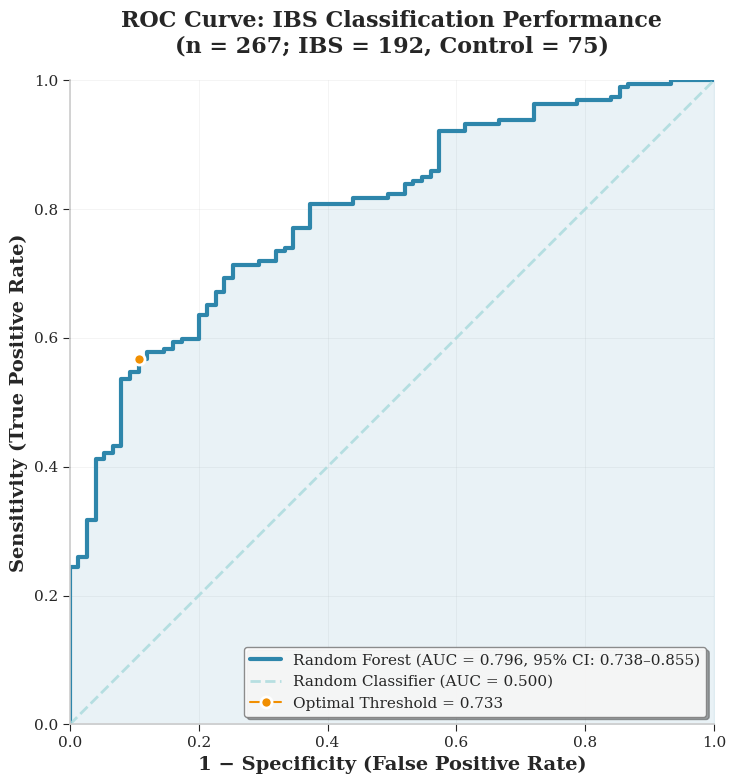

ValueError: too many values to unpack (expected 3)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger("numba").setLevel(logging.WARNING)

# Set academic plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 5,
    'xtick.minor.size': 3,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.fancybox': True,
    'legend.shadow': False
})

selected_cohorts = ['PRJNA812699', 'PRJNA1001944', 'PRJNA789106', 'PRJNA579180']
taxonomy_level = 'genus'

def load_and_process_cohort_data(cohort, taxonomy_level):
    """Load data for a given cohort and taxonomy level, and return processed dataframe."""
    try:
        filename = f"../../dataset/IBS_pivoted/{cohort}_{taxonomy_level}_pivoted.csv"
        df = pd.read_csv(filename)
        feature_cols = [col for col in df.columns if col not in ['id', 'class']]
        df['cohort'] = cohort
        return df, set(feature_cols)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, set()

def calculate_confidence_interval(y_true, y_scores, n_bootstraps=1000, confidence_level=0.95):
    """Calculate confidence interval for ROC curve using bootstrapping."""
    np.random.seed(42)
    
    # Convert to numpy arrays to ensure proper indexing
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    bootstrapped_aucs = []
    n_size = len(y_true)
    
    for _ in range(n_bootstraps):
        # Bootstrap sample
        indices = np.random.choice(n_size, n_size, replace=True)
        y_true_boot = y_true[indices]
        y_scores_boot = y_scores[indices]
        
        # Calculate AUC for bootstrap sample
        try:
            # Check if we have both classes in the bootstrap sample
            if len(np.unique(y_true_boot)) > 1:
                auc_boot = roc_auc_score(y_true_boot, y_scores_boot)
                bootstrapped_aucs.append(auc_boot)
        except:
            continue
    
    # Calculate confidence interval
    if len(bootstrapped_aucs) > 0:
        alpha = 1 - confidence_level
        lower = np.percentile(bootstrapped_aucs, (alpha/2) * 100)
        upper = np.percentile(bootstrapped_aucs, (1 - alpha/2) * 100)
    else:
        # Fallback if bootstrapping fails
        lower = upper = roc_auc_score(y_true, y_scores)
    
    return lower, upper

def plot_academic_roc_curve(y_true, y_scores, model_name="Random Forest", 
                           sample_size=None, positive_cases=None, negative_cases=None):
    """Create publication-ready ROC curve with confidence intervals."""
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    
    # Calculate confidence interval for AUC
    ci_lower, ci_upper = calculate_confidence_interval(y_true, y_scores)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='#2E86AB', linewidth=3, 
            label=f'{model_name} (AUC = {auc_score:.3f}, 95% CI: {ci_lower:.3f}–{ci_upper:.3f})')
    
    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], color='#A8DADC', linestyle='--', linewidth=2, 
            alpha=0.8, label='Random Classifier (AUC = 0.500)')
    
    # Fill area under curve
    ax.fill_between(fpr, tpr, alpha=0.1, color='#2E86AB')
    
    # Customize axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('1 − Specificity (False Positive Rate)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Sensitivity (True Positive Rate)', fontsize=14, fontweight='bold')
    
    # Title with sample information
    title_text = f'ROC Curve: IBS Classification Performance'
    if sample_size:
        subtitle_text = f'(n = {sample_size}'
        if positive_cases and negative_cases:
            subtitle_text += f'; IBS = {positive_cases}, Control = {negative_cases}'
        subtitle_text += ')'
        title_text += f'\n{subtitle_text}'
    
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    
    # Customize legend
    legend = ax.legend(loc='lower right', fontsize=12, frameon=True, 
                      fancybox=True, shadow=True, framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(1)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add optimal threshold point (Youden's J statistic)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    ax.plot(optimal_fpr, optimal_tpr, marker='o', markersize=8, 
            color='#F18F01', markeredgecolor='white', markeredgewidth=2,
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
    
    # Update legend
    legend = ax.legend(loc='lower right', fontsize=11, frameon=True, 
                      fancybox=True, shadow=True, framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    
    plt.tight_layout()
    plt.savefig('academic_roc_curve_combined.pdf', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('academic_roc_curve_combined.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    return auc_score, ci_lower, ci_upper, optimal_threshold

def evaluate_individual_datasets(individual_datasets, param_grid):
    """Evaluate each individual dataset and return comprehensive metrics."""
    
    individual_results = {}
    
    print("\n" + "="*80)
    print("INDIVIDUAL DATASET PERFORMANCE")
    print("="*80)
    
    for cohort, dataset in individual_datasets.items():
        print(f"\nEvaluating {cohort}...")
        
        X = dataset.drop(columns=['class'])
        y = dataset['class']
        
        # Sample information
        total_samples = len(dataset)
        positive_cases = (y == 1).sum()
        negative_cases = (y == 0).sum()
        
        print(f"Dataset size: {total_samples:,} samples")
        print(f"  • IBS cases: {positive_cases:,} ({(positive_cases/total_samples)*100:.1f}%)")
        print(f"  • Control cases: {negative_cases:,} ({(negative_cases/total_samples)*100:.1f}%)")
        
        # Check if we have enough samples for train-test split
        if total_samples < 20:
            print(f"Warning: {cohort} has only {total_samples} samples. Skipping evaluation.")
            continue
        
        # Check if we have both classes
        if len(np.unique(y)) < 2:
            print(f"Warning: {cohort} has only one class. Skipping evaluation.")
            continue
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y
            )
            
            # Grid search for best parameters
            rf = RandomForestClassifier(random_state=42)
            grid_search = GridSearchCV(
                estimator=rf,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1,
                scoring='roc_auc'
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            # Predictions
            y_pred = best_model.predict(X_test)
            y_scores = best_model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            auc = roc_auc_score(y_test, y_scores)
            
            # Calculate specificity and sensitivity
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # Store results
            individual_results[cohort] = {
                'total_samples': total_samples,
                'positive_cases': positive_cases,
                'negative_cases': negative_cases,
                'test_samples': len(y_test),
                'test_positive': (y_test == 1).sum(),
                'test_negative': (y_test == 0).sum(),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'f1': f1,
                'auc': auc,
                'confusion_matrix': {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn},
                'best_params': grid_search.best_params_
            }
            
            # Print results
            print(f"Test set: {len(y_test)} samples (IBS: {(y_test == 1).sum()}, Control: {(y_test == 0).sum()})")
            print(f"Performance Metrics:")
            print(f"  • Accuracy: {accuracy:.3f}")
            print(f"  • Sensitivity: {sensitivity:.3f}")
            print(f"  • Specificity: {specificity:.3f}")
            print(f"  • Precision: {precision:.3f}")
            print(f"  • F1-Score: {f1:.3f}")
            print(f"  • AUC-ROC: {auc:.3f}")
            print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
            
        except Exception as e:
            print(f"Error evaluating {cohort}: {e}")
            continue
    
    return individual_results

def create_comprehensive_summary_table(individual_results, combined_result):
    """Create a comprehensive summary table with all metrics."""
    
    summary_data = []
    
    # Add individual dataset results
    for cohort, result in individual_results.items():
        summary_data.append({
            'Dataset': cohort,
            'Total Samples': f"{result['total_samples']:,}",
            'IBS Cases': f"{result['positive_cases']:,}",
            'Control Cases': f"{result['negative_cases']:,}",
            'IBS %': f"{(result['positive_cases']/result['total_samples'])*100:.1f}%",
            'Test Samples': f"{result['test_samples']:,}",
            'Accuracy': f"{result['accuracy']:.3f}",
            'Sensitivity': f"{result['sensitivity']:.3f}",
            'Specificity': f"{result['specificity']:.3f}",
            'Precision': f"{result['precision']:.3f}",
            'F1-Score': f"{result['f1']:.3f}",
            'AUC': f"{result['auc']:.3f}"
        })
    
    # Add combined dataset result
    summary_data.append({
        'Dataset': 'Combined',
        'Total Samples': f"{combined_result['total_samples']:,}",
        'IBS Cases': f"{combined_result['positive_cases']:,}",
        'Control Cases': f"{combined_result['negative_cases']:,}",
        'IBS %': f"{(combined_result['positive_cases']/combined_result['total_samples'])*100:.1f}%",
        'Test Samples': f"{combined_result['test_samples']:,}",
        'Accuracy': f"{combined_result['accuracy']:.3f}",
        'Sensitivity': f"{combined_result['sensitivity']:.3f}",
        'Specificity': f"{combined_result['specificity']:.3f}",
        'Precision': f"{combined_result['precision']:.3f}",
        'F1-Score': f"{combined_result['f1']:.3f}",
        'AUC': f"{combined_result['auc']:.3f}"
    })
    
    df_summary = pd.DataFrame(summary_data)
    
    print("\n" + "="*120)
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*120)
    print(df_summary.to_string(index=False))
    print("="*120)
    
    return df_summary

# Load and process data
print("Loading and processing cohort data...")
all_dfs = []
all_features = []

for cohort in selected_cohorts:
    df, features = load_and_process_cohort_data(cohort, taxonomy_level)
    if df is not None:
        all_dfs.append(df)
        all_features.append(features)

common_features = set.intersection(*all_features)
print(f"Number of common {taxonomy_level} features across all cohorts: {len(common_features)}")

# Create combined dataset
combined_df = pd.DataFrame()
individual_datasets = {}

for i, df in enumerate(all_dfs):
    cohort = selected_cohorts[i]
    available_common_features = [f for f in common_features if f in df.columns]
    cohort_df = df[['acc', 'class', 'cohort'] + available_common_features]
    
    # Store individual dataset (without acc and cohort columns)
    individual_datasets[cohort] = cohort_df.drop(columns=['acc', 'cohort'])
    
    if i == 0:
        combined_df = cohort_df
    else:
        combined_df = pd.concat([combined_df, cohort_df], ignore_index=True)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# Evaluate individual datasets first
individual_results = evaluate_individual_datasets(individual_datasets, param_grid)

# Prepare combined dataset
dataset = combined_df.drop(columns=['acc', 'cohort'])
X = dataset.drop(columns=['class'])
y = dataset['class']

# Count cases for combined dataset
positive_cases = (y == 1).sum()
negative_cases = (y == 0).sum()
sample_size = len(dataset)

print(f"\n" + "="*60)
print("COMBINED DATASET EVALUATION")
print("="*60)
print(f"Combined dataset: {sample_size:,} samples")
print(f"  • IBS cases: {positive_cases:,} ({(positive_cases/sample_size)*100:.1f}%)")
print(f"  • Control cases: {negative_cases:,} ({(negative_cases/sample_size)*100:.1f}%)")

# Train model
print("\nTraining optimized Random Forest model...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',  # Optimize for AUC
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.3f}")

# Make predictions
y_pred = best_model.predict(X_test)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate combined dataset metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_scores)

# Calculate specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Store combined results
combined_result = {
    'total_samples': sample_size,
    'positive_cases': positive_cases,
    'negative_cases': negative_cases,
    'test_samples': len(y_test),
    'test_positive': (y_test == 1).sum(),
    'test_negative': (y_test == 0).sum(),
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'f1': f1,
    'auc': auc,
    'confusion_matrix': {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn},
    'best_params': grid_search.best_params_
}

print(f"Test set: {len(y_test)} samples (IBS: {(y_test == 1).sum()}, Control: {(y_test == 0).sum()})")
print(f"Performance Metrics:")
print(f"  • Accuracy: {accuracy:.3f}")
print(f"  • Sensitivity: {sensitivity:.3f}")
print(f"  • Specificity: {specificity:.3f}")
print(f"  • Precision: {precision:.3f}")
print(f"  • F1-Score: {f1:.3f}")
print(f"  • AUC-ROC: {auc:.3f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# Create academic ROC curve
print("\nGenerating publication-ready ROC curve...")
auc_score, ci_lower, ci_upper = plot_academic_roc_curve(
    y_test, y_scores, 
    model_name="Random Forest",
    sample_size=len(y_test),
    positive_cases=(y_test == 1).sum(),
    negative_cases=(y_test == 0).sum()
)


Loading and preparing microbiome data...
Columns in PRJNA812699: ['acc', 'Abiotrophia', 'Abrus', 'Absicoccus', 'Absiella']...
Columns in PRJNA1001944: ['acc', 'Abiotrophia', 'Absicoccus', 'Absiella', 'Abyssicoccus']...
Columns in PRJNA789106: ['acc', 'Acetanaerobacterium', 'Acetatifactor', 'Acetitomaculum', 'Acetivibrio']...
Columns in PRJNA579180: ['acc', 'Abiotrophia', 'Acetivibrio', 'Acetomicrobium', 'Achromobacter']...
Found 115 common genus features
Total samples: 1334
IBS samples: 958
Control samples: 376

Filtering features...
Features passing prevalence threshold (10.0%): 113
Features with significant differences (p < 0.05): 72

Creating heatmap with 72 features...


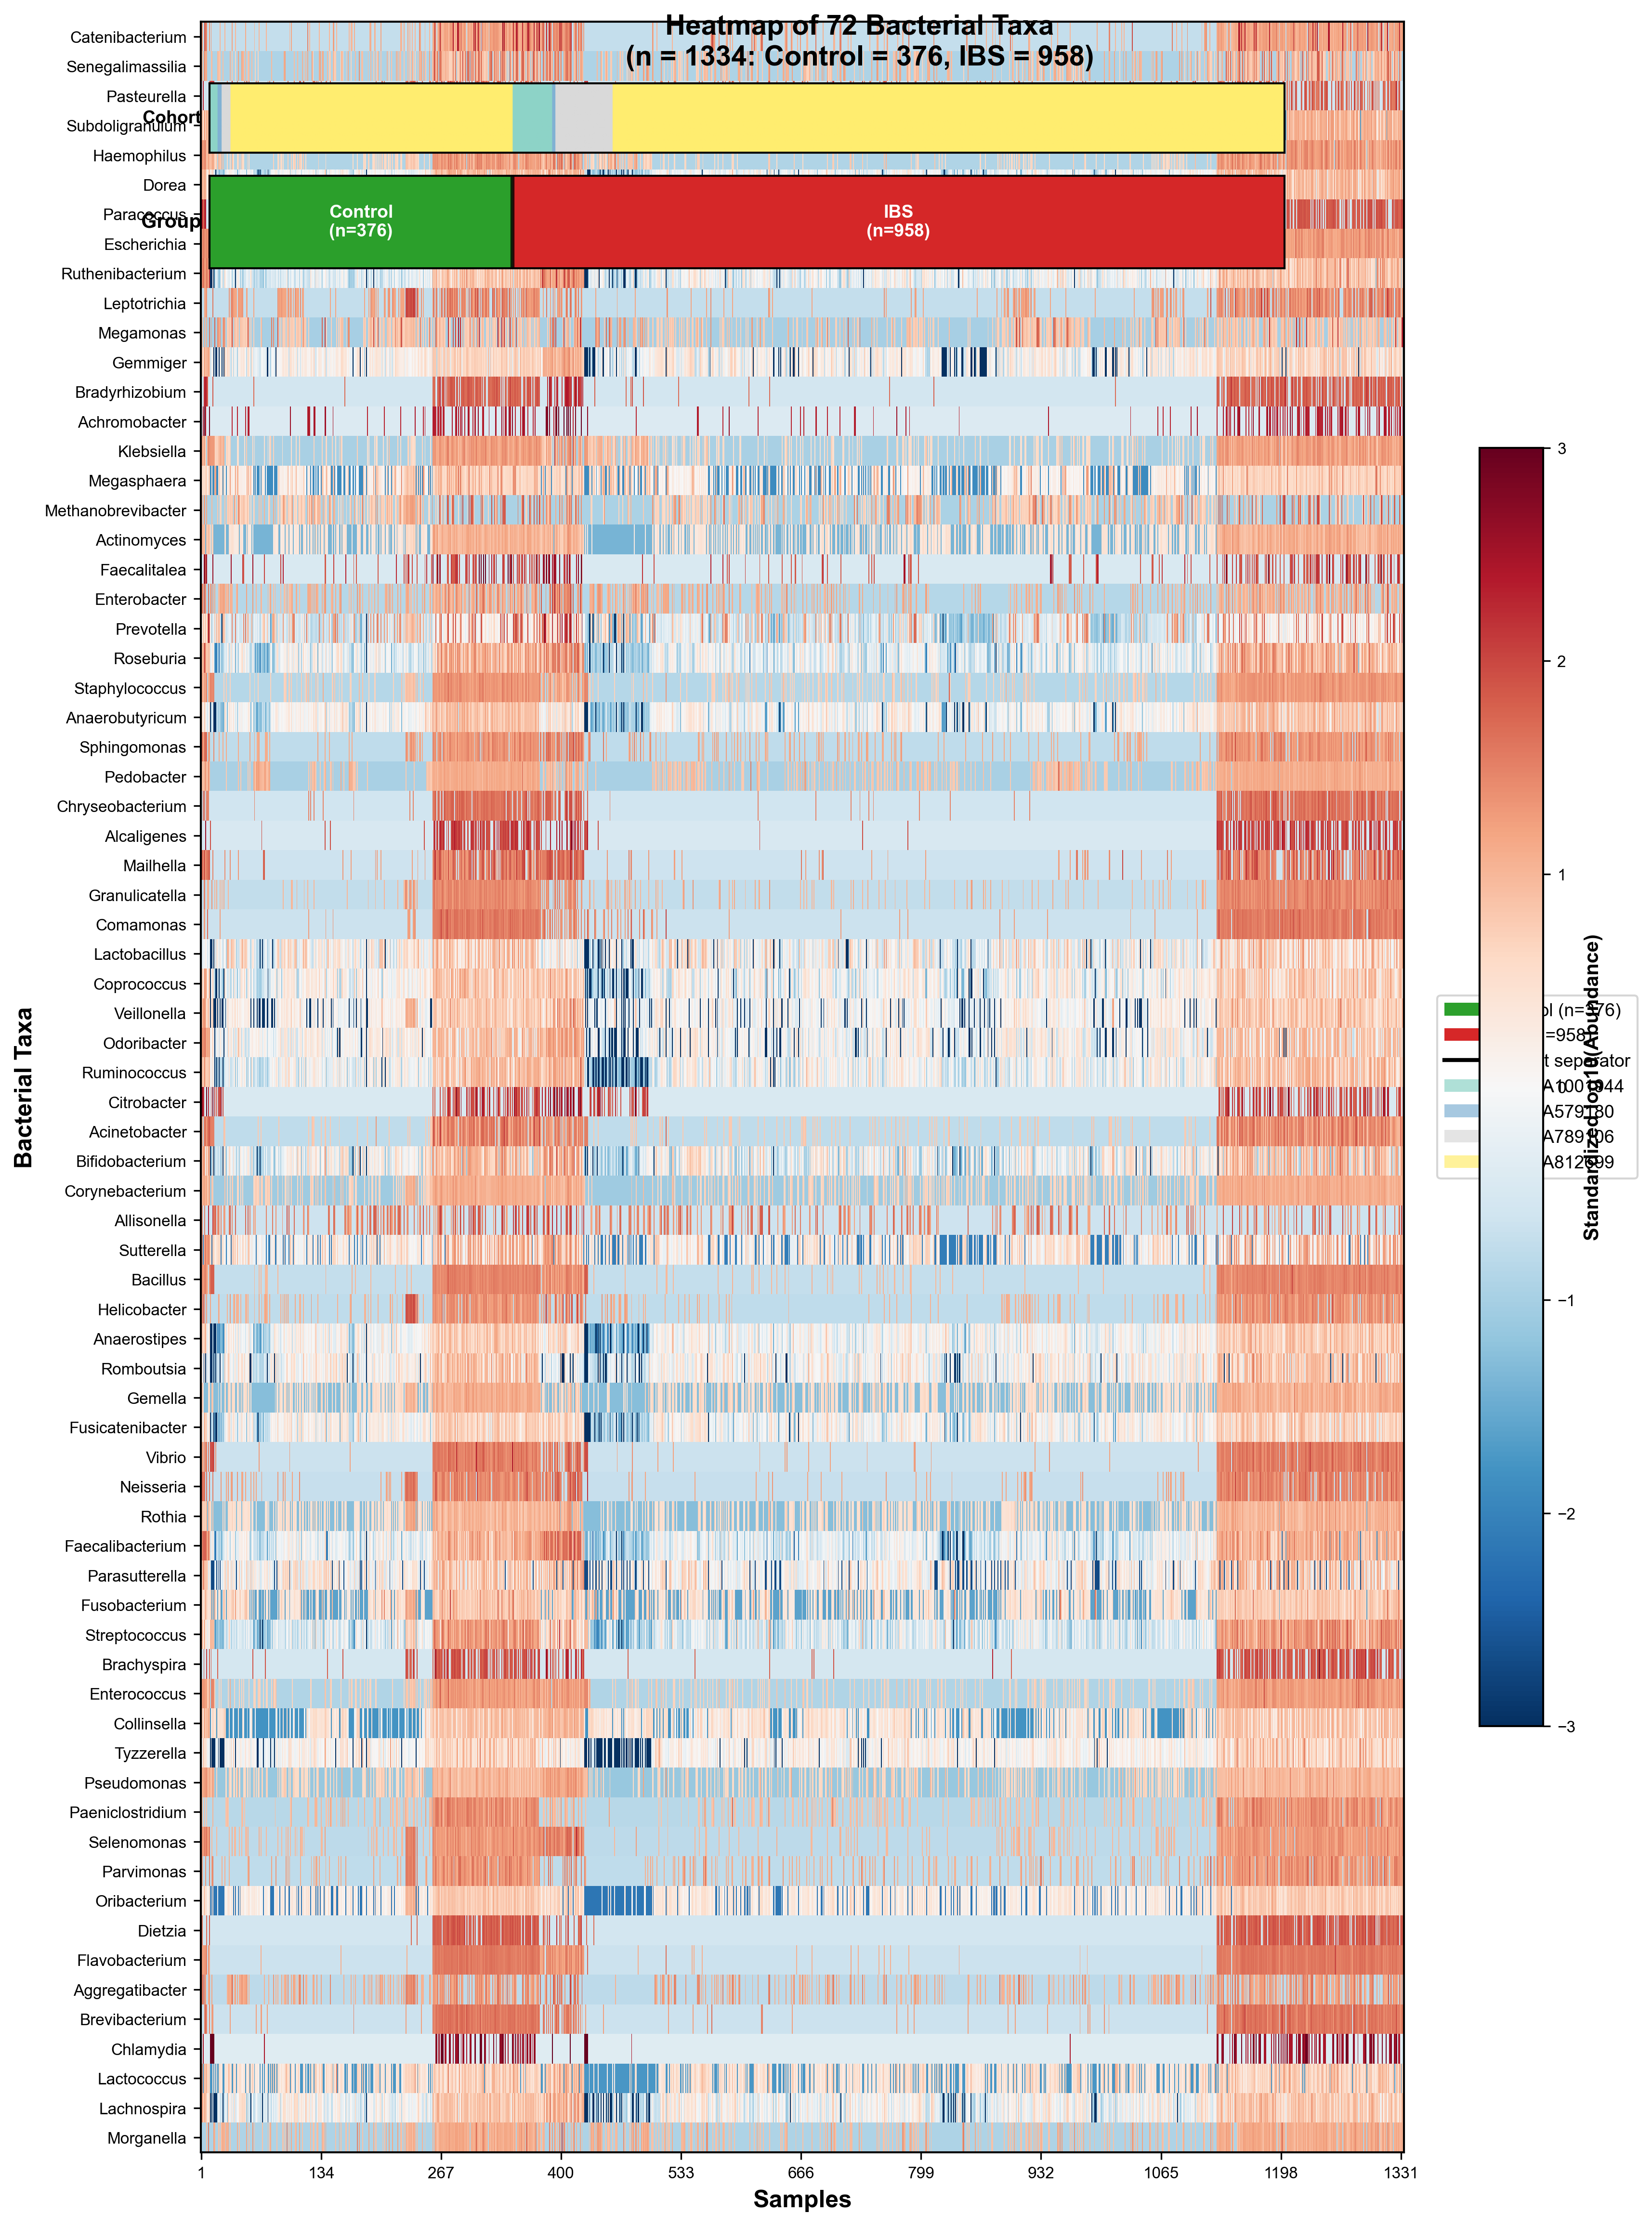


Creating clustered heatmap...


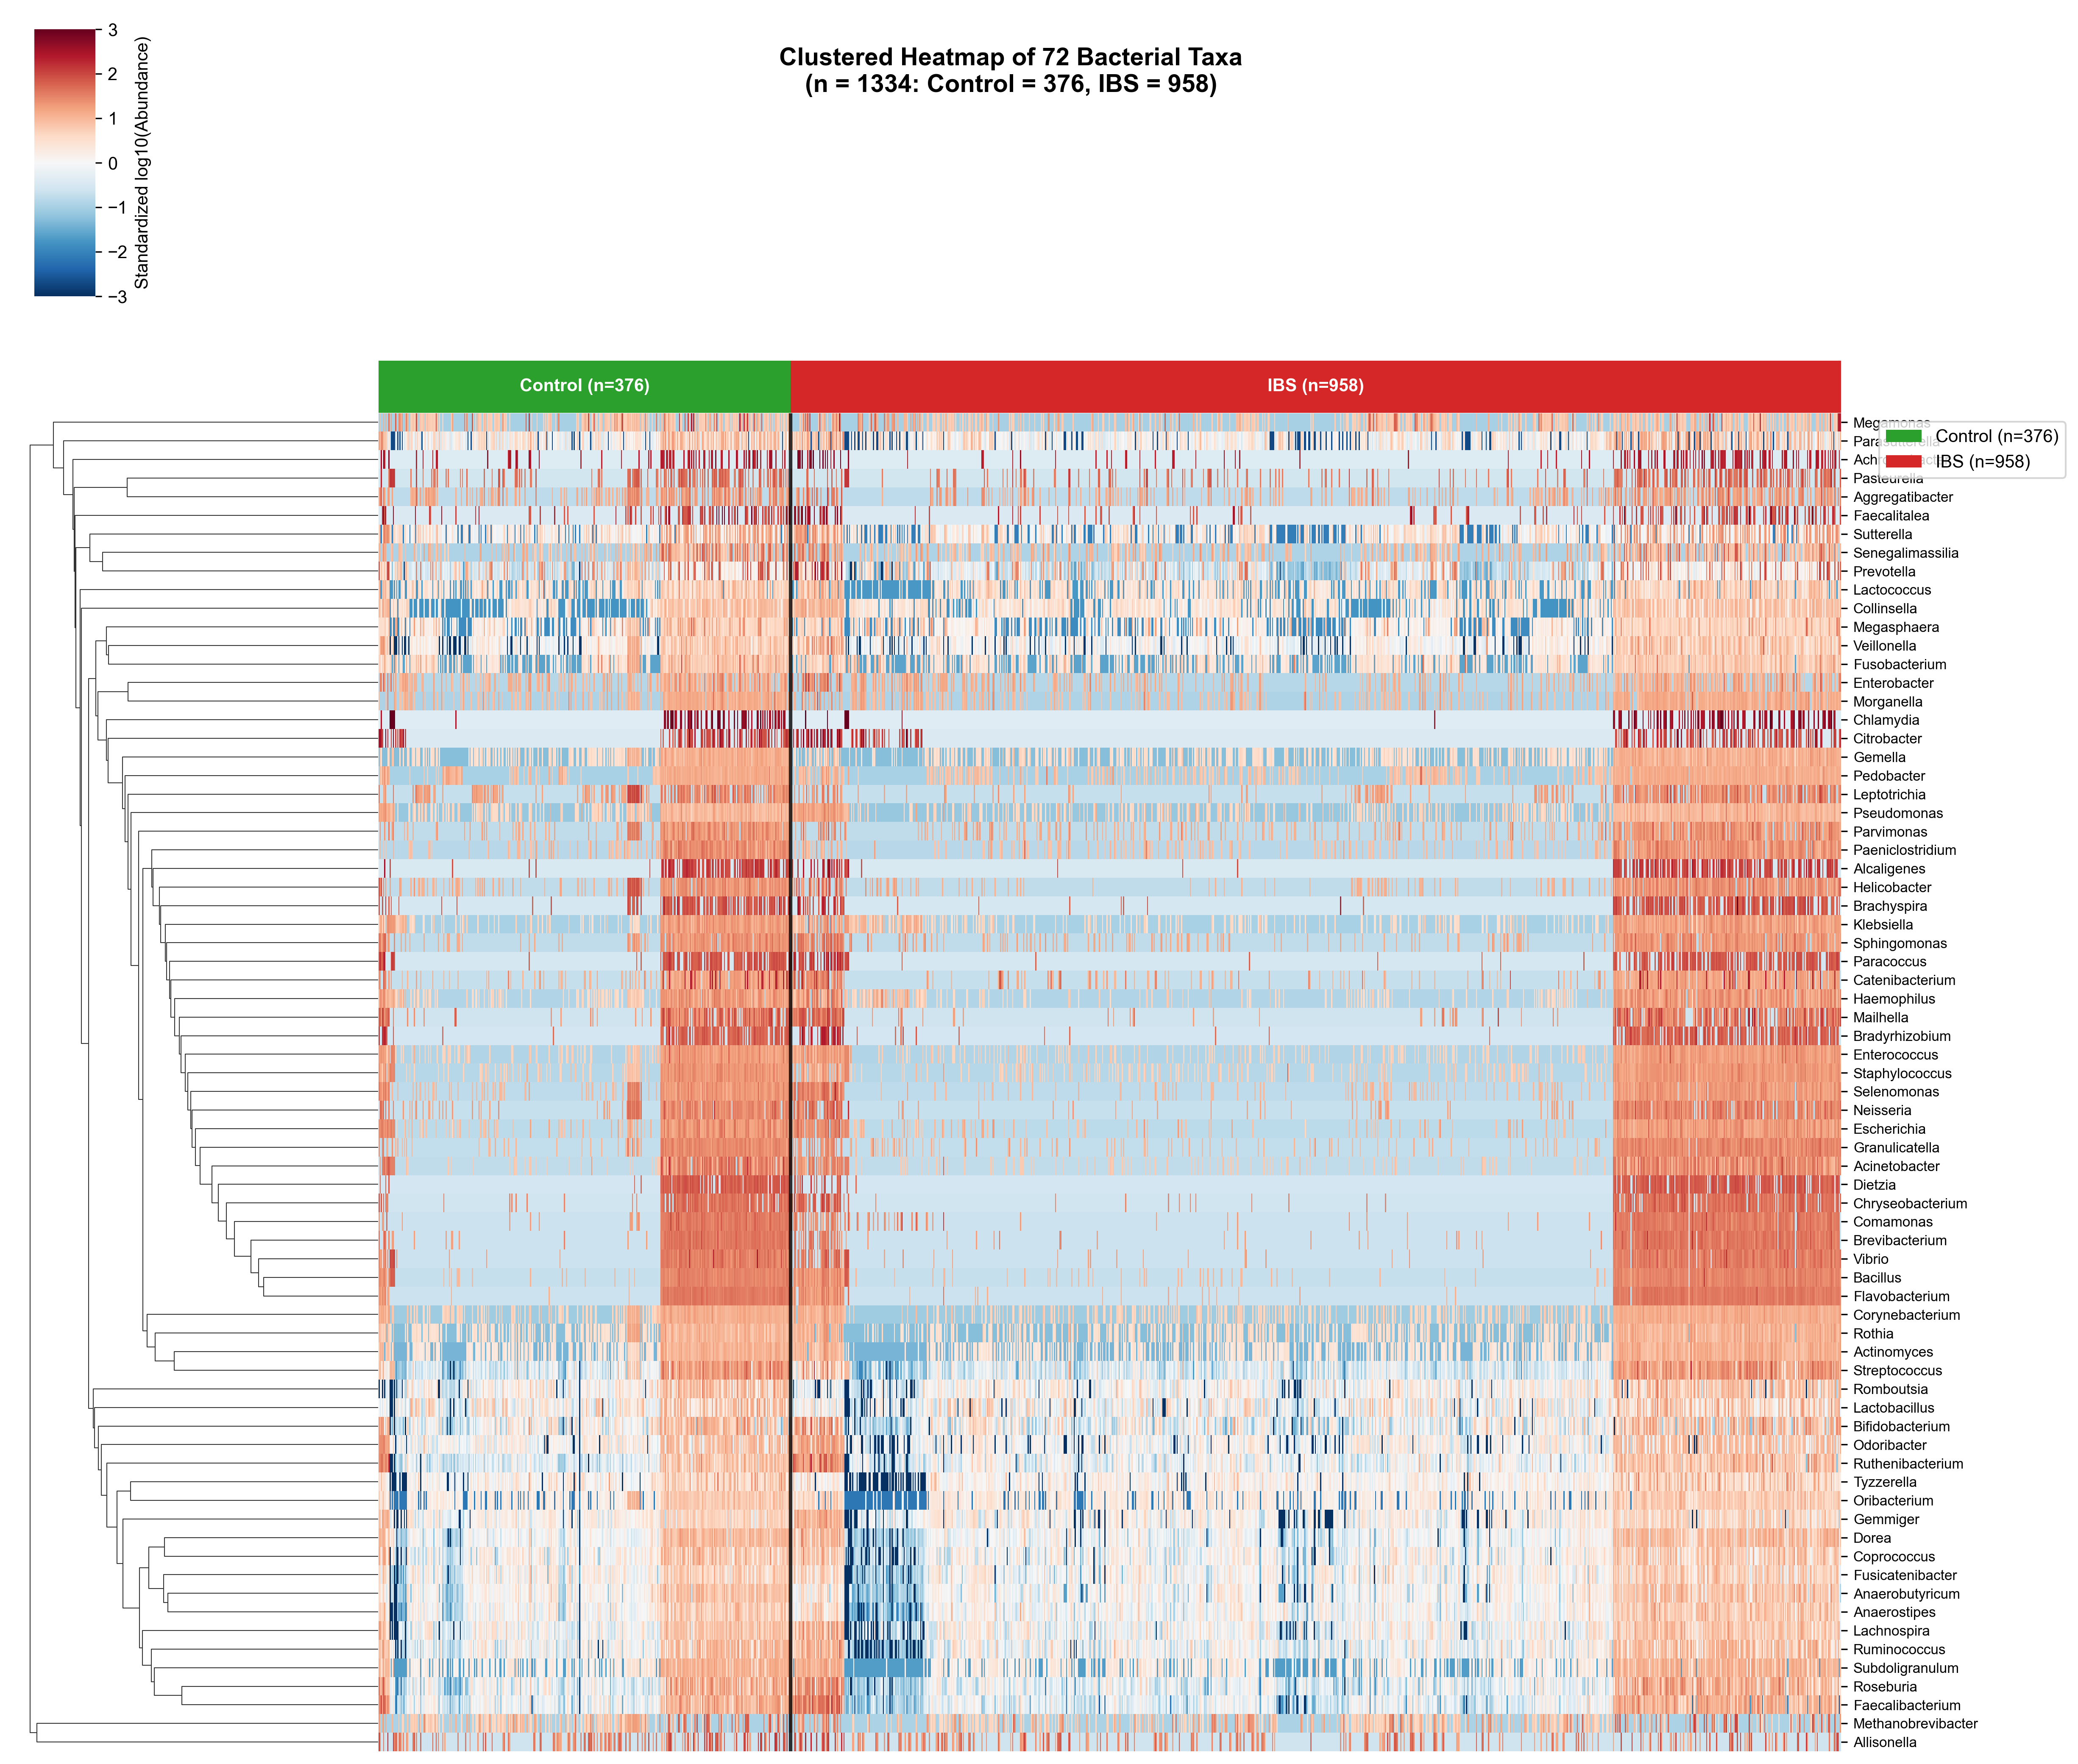


DATASET SUMMARY
Total samples: 1,334
IBS samples: 958
Control samples: 376
Total features analyzed: 115
Significant features displayed: 72

Cohort breakdown:
  PRJNA812699: 1184 samples (IBS: 834, Control: 350)
  PRJNA1001944: 59 samples (IBS: 49, Control: 10)
  PRJNA789106: 82 samples (IBS: 71, Control: 11)
  PRJNA579180: 9 samples (IBS: 4, Control: 5)

Files saved:
  • microbiome_heatmap_standard.pdf/png
  • microbiome_heatmap_clustered.pdf/png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb
import warnings
warnings.filterwarnings("ignore")

# Set publication style
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'Arial',
    'axes.linewidth': 1,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def load_and_prepare_data(selected_cohorts, taxonomy_level='genus'):
    """Load and combine data from multiple cohorts."""
    
    def load_cohort_data(cohort, taxonomy_level):
        try:
            filename = f"../../dataset/IBS_pivoted/{cohort}_{taxonomy_level}_pivoted.csv"
            df = pd.read_csv(filename)
            df['cohort'] = cohort
            
            # Check what columns exist
            print(f"Columns in {cohort}: {list(df.columns)[:5]}...")  # Show first 5 columns
            
            # Find ID column (could be 'id', 'acc', 'sample_id', etc.)
            id_columns = ['id', 'acc', 'sample_id', 'sample', 'ID']
            id_col = None
            for col in id_columns:
                if col in df.columns:
                    id_col = col
                    break
            
            if id_col is None:
                # If no ID column found, create one
                df['sample_id'] = range(len(df))
                id_col = 'sample_id'
            
            # Exclude metadata columns to find features
            metadata_cols = [id_col, 'class', 'cohort']
            features = set([col for col in df.columns if col not in metadata_cols])
            
            return df, features, id_col
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return None, set(), None
    
    all_dfs = []
    all_features = []
    id_columns = []
    
    for cohort in selected_cohorts:
        df, features, id_col = load_cohort_data(cohort, taxonomy_level)
        if df is not None:
            all_dfs.append(df)
            all_features.append(features)
            id_columns.append(id_col)
    
    # Find common features
    common_features = set.intersection(*all_features)
    print(f"Found {len(common_features)} common {taxonomy_level} features")
    
    # Combine datasets
    combined_df = pd.DataFrame()
    for i, df in enumerate(all_dfs):
        id_col = id_columns[i]
        available_features = [f for f in common_features if f in df.columns]
        
        # Select columns that exist
        columns_to_select = [id_col, 'class', 'cohort'] + available_features
        cohort_df = df[columns_to_select].copy()
        
        # Standardize ID column name
        cohort_df = cohort_df.rename(columns={id_col: 'sample_id'})
        
        if i == 0:
            combined_df = cohort_df
        else:
            combined_df = pd.concat([combined_df, cohort_df], ignore_index=True)
    
    return combined_df, list(common_features)

def filter_features_by_prevalence_and_significance(df, features, prevalence_threshold=0.1, p_value_threshold=0.05):
    """Filter features based on prevalence and statistical significance."""
    
    # Separate features and metadata
    feature_data = df[features]
    classes = df['class']
    
    # Filter by prevalence (present in at least X% of samples)
    prevalence_mask = (feature_data > 0).mean(axis=0) >= prevalence_threshold
    prevalent_features = feature_data.columns[prevalence_mask].tolist()
    
    print(f"Features passing prevalence threshold ({prevalence_threshold*100}%): {len(prevalent_features)}")
    
    # Test for statistical significance between groups
    significant_features = []
    p_values = []
    
    ibs_data = feature_data[classes == 1]
    control_data = feature_data[classes == 0]
    
    for feature in prevalent_features:
        try:
            # Mann-Whitney U test (non-parametric)
            statistic, p_value = mannwhitneyu(
                ibs_data[feature], 
                control_data[feature], 
                alternative='two-sided'
            )
            p_values.append(p_value)
            if p_value < p_value_threshold:
                significant_features.append(feature)
        except:
            p_values.append(1.0)  # If test fails, assign non-significant p-value
    
    print(f"Features with significant differences (p < {p_value_threshold}): {len(significant_features)}")
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'feature': prevalent_features,
        'p_value': p_values
    })
    
    return significant_features, results_df

def create_microbiome_heatmap(df, features, max_features=100, figsize=(12, 16)):
    """Create a publication-ready microbiome heatmap."""
    
    # Prepare data matrix
    sample_data = df[['sample_id', 'class', 'cohort'] + features].copy()
    
    # Log-transform the data (add pseudocount to avoid log(0))
    feature_matrix = sample_data[features]
    log_transformed = np.log10(feature_matrix + 1e-6)  # Add small pseudocount
    
    # Standardize features (z-score)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_transformed)
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=sample_data.index)
    
    # Sort samples by class (Control=0 first, then IBS=1) to group them visually
    sample_data_sorted = sample_data.sort_values(['class', 'cohort'], ascending=[True, True])
    scaled_df_sorted = scaled_df.loc[sample_data_sorted.index]
    
    # Limit number of features if necessary
    if len(features) > max_features:
        # Select top features by variance
        feature_variance = scaled_df_sorted.var(axis=0)
        top_features = feature_variance.nlargest(max_features).index.tolist()
        scaled_df_sorted = scaled_df_sorted[top_features]
        features = top_features
        print(f"Limited to top {max_features} most variable features")
    
    # Create the plot with more space at top for annotations
    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(top=0.82)  # Make more room at top
    
    # Create heatmap
    im = ax.imshow(scaled_df_sorted.T, aspect='auto', cmap='RdBu_r', 
                   vmin=-3, vmax=3, interpolation='nearest')
    
    # Customize axes
    ax.set_xlabel('Samples', fontsize=12, fontweight='bold')
    ax.set_ylabel('Bacterial Taxa', fontsize=12, fontweight='bold')
    
    # Set sample labels and ticks
    n_samples = len(sample_data_sorted)
    sample_ticks = np.arange(0, n_samples, max(1, n_samples//10))
    ax.set_xticks(sample_ticks)
    ax.set_xticklabels([f'{i+1}' for i in sample_ticks], fontsize=8)
    
    # Set feature labels
    ax.set_yticks(range(len(features)))
    # Clean up feature names (remove common prefixes)
    clean_features = []
    for feature in features:
        # Remove common taxonomic prefixes
        clean_name = feature.replace('g__', '').replace('s__', '').replace('f__', '')
        clean_name = clean_name.replace('o__', '').replace('c__', '').replace('p__', '')
        # Limit length
        if len(clean_name) > 30:
            clean_name = clean_name[:27] + '...'
        clean_features.append(clean_name)
    
    ax.set_yticklabels(clean_features, fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Standardized log10(Abundance)', fontsize=10, fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    # Count samples by group
    control_samples = (sample_data_sorted['class'] == 0).sum()
    ibs_samples = (sample_data_sorted['class'] == 1).sum()
    
    # Create Group annotation bar at the top
    ax_group = fig.add_axes([ax.get_position().x0, 0.85, ax.get_position().width, 0.04])
    
    # Create color array for groups using numerical values
    group_color_array = np.zeros((1, n_samples, 3))  # RGB array
    
    for i, class_val in enumerate(sample_data_sorted['class']):
        if class_val == 0:  # Control
            group_color_array[0, i] = [0.172, 0.627, 0.172]  # Green RGB
        else:  # IBS
            group_color_array[0, i] = [0.839, 0.153, 0.157]  # Red RGB
    
    # Plot the group annotation
    ax_group.imshow(group_color_array, aspect='auto', extent=[0, n_samples, 0, 1])
    ax_group.set_xlim(0, n_samples)
    ax_group.set_ylim(0, 1)
    ax_group.set_xticks([])
    ax_group.set_yticks([])
    ax_group.set_ylabel('Group', fontsize=10, fontweight='bold', rotation=0, 
                       ha='right', va='center')
    
    # Add vertical line to separate groups
    control_end = control_samples
    ax_group.axvline(x=control_end, color='black', linewidth=2, alpha=0.8)
    
    # Add group labels on the annotation bar
    ax_group.text(control_samples/2, 0.5, f'Control\n(n={control_samples})', 
                 ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax_group.text(control_samples + ibs_samples/2, 0.5, f'IBS\n(n={ibs_samples})', 
                 ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    # Cohort annotation (if multiple cohorts)
    cohorts = sample_data_sorted['cohort'].unique()
    if len(cohorts) > 1:
        ax_cohort = fig.add_axes([ax.get_position().x0, 0.90, ax.get_position().width, 0.03])
        
        # Create cohort color array
        cohort_color_array = np.zeros((1, n_samples, 3))  # RGB array
        cohort_colors_palette = plt.cm.Set3(np.linspace(0, 1, len(cohorts)))
        cohort_color_map = {cohort: cohort_colors_palette[i] for i, cohort in enumerate(cohorts)}
        
        for i, cohort in enumerate(sample_data_sorted['cohort']):
            cohort_color_array[0, i] = cohort_color_map[cohort][:3]  # Take RGB, ignore alpha
        
        ax_cohort.imshow(cohort_color_array, aspect='auto', extent=[0, n_samples, 0, 1])
        ax_cohort.set_xlim(0, n_samples)
        ax_cohort.set_ylim(0, 1)
        ax_cohort.set_xticks([])
        ax_cohort.set_yticks([])
        ax_cohort.set_ylabel('Cohort', fontsize=9, fontweight='bold', rotation=0, 
                           ha='right', va='center')
    
    # Add main title
    title = f'Heatmap of {len(features)} Bacterial Taxa\n'
    title += f'(n = {n_samples}: Control = {control_samples}, IBS = {ibs_samples})'
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.96)
    
    # Create legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#2ca02c', label=f'Control (n={control_samples})'),
        plt.Rectangle((0,0),1,1, facecolor='#d62728', label=f'IBS (n={ibs_samples})')
    ]
    
    # Add cohort legend if multiple cohorts
    if len(cohorts) > 1:
        legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=2, 
                                        label='Cohort separator'))
        for i, cohort in enumerate(cohorts):
            legend_elements.append(
                plt.Rectangle((0,0),1,1, facecolor=cohort_colors_palette[i], 
                            label=f'{cohort}', alpha=0.7)
            )
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
             fontsize=9)
    
    plt.tight_layout()
    
    return fig, ax, sample_data_sorted

def create_clustered_heatmap(df, features, max_features=100):
    """Create a clustered heatmap with dendrograms."""
    
    # Prepare data
    sample_data = df[['sample_id', 'class', 'cohort'] + features].copy()
    feature_matrix = sample_data[features]
    log_transformed = np.log10(feature_matrix + 1e-6)
    
    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_transformed)
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=sample_data.index)
    
    # Limit features if necessary
    if len(features) > max_features:
        feature_variance = scaled_df.var(axis=0)
        top_features = feature_variance.nlargest(max_features).index.tolist()
        scaled_df = scaled_df[top_features]
        features = top_features
    
    # Sort samples by class for better visualization (Control first, then IBS)
    sample_data_sorted = sample_data.sort_values(['class', 'cohort'], ascending=[True, True])
    scaled_df_sorted = scaled_df.loc[sample_data_sorted.index]
    
    # Create annotation dataframe
    annotation_df = sample_data_sorted[['class', 'cohort']].copy()
    annotation_df['Group'] = annotation_df['class'].map({0: 'Control', 1: 'IBS'})
    
    # Create color maps
    group_colors = {'Control': '#2ca02c', 'IBS': '#d62728'}
    cohorts = annotation_df['cohort'].unique()
    cohort_colors = {cohort: plt.cm.Set3(i/len(cohorts)) for i, cohort in enumerate(cohorts)}
    
    # Prepare column colors (samples)
    col_colors_group = [group_colors[x] for x in annotation_df['Group']]
    
    # Create the clustered heatmap
    g = sns.clustermap(
        scaled_df_sorted.T,  # Transpose so features are rows
        cmap='RdBu_r',
        center=0,
        vmin=-3, vmax=3,
        figsize=(16, 14),
        cbar_pos=(0.02, 0.83, 0.03, 0.15),
        row_cluster=True,
        col_cluster=False,  # Don't cluster columns to maintain group separation
        col_colors=col_colors_group,
        linewidths=0,
        xticklabels=False,
        yticklabels=True,
        cbar_kws={'label': 'Standardized log10(Abundance)'}
    )
    
    # Clean up y-axis labels (feature names)
    clean_labels = []
    for label in g.ax_heatmap.get_yticklabels():
        text = label.get_text()
        clean_name = text.replace('g__', '').replace('s__', '').replace('f__', '')
        clean_name = clean_name.replace('o__', '').replace('c__', '').replace('p__', '')
        if len(clean_name) > 35:
            clean_name = clean_name[:32] + '...'
        clean_labels.append(clean_name)
    
    g.ax_heatmap.set_yticklabels(clean_labels, fontsize=8)
    
    # Add vertical line to separate groups
    control_samples = (annotation_df['class'] == 0).sum()
    g.ax_heatmap.axvline(x=control_samples, color='black', linewidth=2, alpha=0.8)
    
    # Add title
    n_samples = len(sample_data_sorted)
    ibs_samples = (annotation_df['class'] == 1).sum()
    control_samples = (annotation_df['class'] == 0).sum()
    
    g.fig.suptitle(f'Clustered Heatmap of {len(features)} Bacterial Taxa\n' +
                   f'(n = {n_samples}: Control = {control_samples}, IBS = {ibs_samples})',
                   fontsize=14, fontweight='bold', y=0.97)
    
    # Add group labels to the top
    g.ax_col_colors.text(control_samples/2, 0.5, f'Control (n={control_samples})', 
                        ha='center', va='center', fontsize=10, fontweight='bold', 
                        color='white', transform=g.ax_col_colors.transData)
    g.ax_col_colors.text(control_samples + ibs_samples/2, 0.5, f'IBS (n={ibs_samples})', 
                        ha='center', va='center', fontsize=10, fontweight='bold', 
                        color='white', transform=g.ax_col_colors.transData)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#2ca02c', label=f'Control (n={control_samples})'),
        plt.Rectangle((0,0),1,1, facecolor='#d62728', label=f'IBS (n={ibs_samples})')
    ]
    
    g.ax_heatmap.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1),
                       fontsize=10)
    
    return g

# Main execution
if __name__ == "__main__":
    # Configuration
    selected_cohorts = ['PRJNA812699', 'PRJNA1001944', 'PRJNA789106', 'PRJNA579180']
    taxonomy_level = 'genus'
    
    print("Loading and preparing microbiome data...")
    
    # Load data
    combined_df, all_features = load_and_prepare_data(selected_cohorts, taxonomy_level)
    
    print(f"Total samples: {len(combined_df)}")
    print(f"IBS samples: {(combined_df['class'] == 1).sum()}")
    print(f"Control samples: {(combined_df['class'] == 0).sum()}")
    
    # Filter features by prevalence and significance
    print("\nFiltering features...")
    significant_features, stats_df = filter_features_by_prevalence_and_significance(
        combined_df, all_features, 
        prevalence_threshold=0.1,  # Present in at least 10% of samples
        p_value_threshold=0.05     # Significantly different between groups
    )
    
    if len(significant_features) == 0:
        print("No significant features found. Using top 50 most prevalent features.")
        feature_data = combined_df[all_features]
        prevalence = (feature_data > 0).mean(axis=0)
        significant_features = prevalence.nlargest(50).index.tolist()
    
    # Create standard heatmap
    print(f"\nCreating heatmap with {len(significant_features)} features...")
    fig1, ax1, sorted_data = create_microbiome_heatmap(
        combined_df, significant_features, 
        max_features=100, 
        figsize=(12, 16)
    )
    
    plt.savefig('microbiome_heatmap_standard.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('microbiome_heatmap_standard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create clustered heatmap
    print("\nCreating clustered heatmap...")
    fig2 = create_clustered_heatmap(
        combined_df, significant_features,
        max_features=80
    )
    
    plt.savefig('microbiome_heatmap_clustered.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('microbiome_heatmap_clustered.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DATASET SUMMARY")
    print("="*60)
    print(f"Total samples: {len(combined_df):,}")
    print(f"IBS samples: {(combined_df['class'] == 1).sum():,}")
    print(f"Control samples: {(combined_df['class'] == 0).sum():,}")
    print(f"Total features analyzed: {len(all_features):,}")
    print(f"Significant features displayed: {len(significant_features):,}")
    
    # Cohort breakdown
    print(f"\nCohort breakdown:")
    for cohort in selected_cohorts:
        cohort_data = combined_df[combined_df['cohort'] == cohort]
        ibs_count = (cohort_data['class'] == 1).sum()
        control_count = (cohort_data['class'] == 0).sum()
        print(f"  {cohort}: {len(cohort_data)} samples (IBS: {ibs_count}, Control: {control_count})")
    
    print("\nFiles saved:")
    print("  • microbiome_heatmap_standard.pdf/png")
    print("  • microbiome_heatmap_clustered.pdf/png")
    print("="*60)

In [3]:
df = combined_df.drop(columns=['acc', 'cohort'])

X = df.drop(columns=['class'])
y = df['class']

param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 
    n_jobs=-1,            
    verbose=1,              
    scoring='accuracy',   
    return_train_score=True
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 300}


In [4]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7228464419475655


In [5]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_  
})
top_30_features = importances.nlargest(30, 'importance')['feature'].values
print(top_30_features)

['Collinsella' 'Faecalibacterium' 'Ruthenibacterium' 'Prevotella'
 'Lactobacillus' 'Odoribacter' 'Akkermansia' 'Bacteroides' 'Oscillibacter'
 'Anaerotruncus' 'Anaerobutyricum' 'Blautia' 'Intestinimonas'
 'Flavonifractor' 'Coprococcus' 'Sutterella' 'Butyricimonas' 'Roseburia'
 'Lachnoclostridium' 'Parabacteroides' 'Porphyromonas' 'Dorea'
 'Hungatella' 'Anaerostipes' 'Oribacterium' 'Eisenbergiella'
 'Fusobacterium' 'Romboutsia' 'Veillonella' 'Leptotrichia']


In [35]:
df = combined_df.drop(columns=['acc', 'cohort'])

X = df.drop(columns=['class'])
y = df['class']

X = X[['Collinsella', 'Bacteroides' ,'Ruthenibacterium', 'Lactobacillus',
 'Faecalibacterium' ,'Prevotella' ,'Akkermansia' ,'Oscillibacter',
 'Anaerotruncus', 'Odoribacter', 'Lachnoclostridium', 'Butyricimonas',
 'Porphyromonas' ,'Hungatella', 'Flavonifractor', 'Alistipes',
 'Parabacteroides' ,'Anaerobutyricum', 'Dorea', 'Bifidobacterium',
 'Fusicatenibacter', 'Leptotrichia', 'Gemella', 'Intestinimonas',
 'Fusobacterium', 'Coprococcus' ,'Tyzzerella', 'Eisenbergiella',
 'Anaerostipes', 'Paraprevotella']]

param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }

y = df['class']

param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 
    n_jobs=-1,            
    verbose=1,              
    scoring='accuracy',   
    return_train_score=True
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Fitting 3 folds for each of 108 candidates, totalling 324 fits
=== MODEL PERFORMANCE METRICS ===
Test Set Performance:
Accuracy: 0.738
Precision: 0.741
Recall: 0.957
F1-Score: 0.835
AUC-ROC: 0.757
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== CROSS-VALIDATION RESULTS (5-fold) ===
Accuracy: 0.751 ± 0.020
Precision: 0.766 ± 0.017
Recall: 0.942 ± 0.014
F1-Score: 0.845 ± 0.011
AUC-ROC: 0.775 ± 0.026

=== DATASET INFORMATION ===
Total samples: 1334
Training samples: 1067
Test samples: 267
Number of features: 30
Class distribution: [376 958]
Class balance: 71.8% IBS patients

=== FORMATTED FOR PAPER ===
Model Performance on Integrated Microbiome Dataset:
Accuracy: 0.74
Precision: 0.74
Recall: 0.96
F1-Score: 0.83
AUC-ROC: 0.76
Cross-validation accuracy: 0.75 ± 0.02


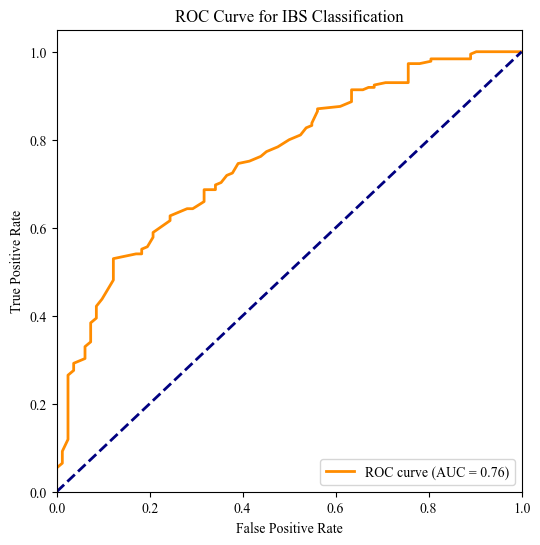

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# Your existing code up to model training...
df = combined_df.drop(columns=['acc', 'cohort'])
X = df.drop(columns=['class'])
y = df['class']

X = X[['Collinsella', 'Bacteroides' ,'Ruthenibacterium', 'Lactobacillus',
 'Faecalibacterium' ,'Prevotella' ,'Akkermansia' ,'Oscillibacter',
 'Anaerotruncus', 'Odoribacter', 'Lachnoclostridium', 'Butyricimonas',
 'Porphyromonas' ,'Hungatella', 'Flavonifractor', 'Alistipes',
 'Parabacteroides' ,'Anaerobutyricum', 'Dorea', 'Bifidobacterium',
 'Fusicatenibacter', 'Leptotrichia', 'Gemella', 'Intestinimonas',
 'Fusobacterium', 'Coprococcus' ,'Tyzzerella', 'Eisenbergiella',
 'Anaerostipes', 'Paraprevotella']]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 
    n_jobs=-1,            
    verbose=1,              
    scoring='accuracy',   
    return_train_score=True
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
best_params = grid_search.best_params_

# ==================== NEW CODE FOR PAPER METRICS ====================

# 1. Basic Performance Metrics on Test Set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Test Set Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")
print(f"Best Parameters: {best_params}")

# 2. Cross-Validation Performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
cv_recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
cv_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

print(f"\n=== CROSS-VALIDATION RESULTS (5-fold) ===")
print(f"Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Precision: {cv_precision.mean():.3f} ± {cv_precision.std():.3f}")
print(f"Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")
print(f"F1-Score: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
print(f"AUC-ROC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

# 3. Dataset Information
print(f"\n=== DATASET INFORMATION ===")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class balance: {np.bincount(y)[1]/len(y)*100:.1f}% IBS patients")

# 4. Create a summary table for the paper
print(f"\n=== FORMATTED FOR PAPER ===")
print("Model Performance on Integrated Microbiome Dataset:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc_roc:.2f}")
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# 5. Optional: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for IBS Classification')
plt.legend(loc="lower right")
plt.show()

In [36]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7378277153558053


In [18]:
predicted_probabilities = model.predict_proba(X)
prob_df = pd.DataFrame(predicted_probabilities[:,1], columns=['IBS'])
result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)
result_df.to_excel('../../dataset/IBS_species/Predicted_Probabilites_4_cohorts_genus_pivoted.xlsx', index=False)

In [6]:
X_train['IBS'] = model.predict_proba(X_train)[:,1]

In [7]:
from fast_causal_inference import FastCausalInference
result_dir = '../../result/R/'
ci = FastCausalInference(data=X_train, model=model, target_variable='IBS')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS_4_cohorts_genus_pivoted.json')
x_instance = X_train.iloc[33]

print(ci.compute_modified_shap_proba(x_instance, is_classifier=True))

Removed 1 edges to make the graph acyclic:
  IBS -> Leptotrichia (weight: -0.06590075)
{'Collinsella': np.float64(-0.005485852676355144), 'Bacteroides': np.float64(0.0), 'Ruthenibacterium': np.float64(-0.00929829967419252), 'Lactobacillus': np.float64(-0.37480632336153913), 'Faecalibacterium': np.float64(0.029327870288672352), 'Prevotella': np.float64(-0.005109614359542896), 'Akkermansia': np.float64(0.0), 'Oscillibacter': np.float64(0.0), 'Anaerotruncus': np.float64(0.0), 'Odoribacter': np.float64(0.023522073390003017), 'Lachnoclostridium': np.float64(0.0), 'Butyricimonas': np.float64(0.0), 'Porphyromonas': np.float64(-0.019486551152835745), 'Hungatella': np.float64(0.0), 'Flavonifractor': np.float64(0.0), 'Alistipes': np.float64(0.0), 'Parabacteroides': np.float64(0.0), 'Anaerobutyricum': np.float64(0.0010945690819114692), 'Dorea': np.float64(0.02967943309834455), 'Bifidobacterium': np.float64(0.0), 'Fusicatenibacter': np.float64(-0.06570464516461585), 'Leptotrichia': np.float64(0.01

In [22]:
from tqdm import tqdm

phi = []
for i in tqdm(range(len(X_test)), desc="Computing SHAP values", unit="sample"):
    phi.append(ci.compute_modified_shap_proba(X_test.iloc[i], is_classifier=True))

phi_df = pd.DataFrame(phi)
mean_values = phi_df.abs().mean()
global_importance = mean_values.sort_values(ascending=False)

Computing SHAP values:   0%|          | 0/267 [00:00<?, ?sample/s]

Computing SHAP values: 100%|██████████| 267/267 [06:11<00:00,  1.39s/sample]


In [22]:
# Initialize FastCausalInference
from fast_causal_inference import FastCausalInference
result_dir = '../../result/R/'

# Create a copy of X_train and add the IBS target variable (predicted probabilities)
X_train_with_target = X_train.copy()
X_train_with_target['IBS'] = model.predict_proba(X_train)[:,1]

# Initialize with the data that includes the target variable
ci = FastCausalInference(data=X_train_with_target, model=model, target_variable='IBS')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS_4_cohorts_genus_pivoted.json')

# Get examples of both classes
non_ibs_indices = y_train[y_train == 0].index
ibs_indices = y_train[y_train == 1].index

print(f"Number of non-IBS patients: {len(non_ibs_indices)}")
print(f"Number of IBS patients: {len(ibs_indices)}")

# Select representative instances (just the index numbers)
non_ibs_instance_idx = non_ibs_indices[0] if len(non_ibs_indices) > 0 else None
ibs_instance_idx = ibs_indices[0] if len(ibs_indices) > 0 else None

# Compute SHAP scores for non-IBS patient
if non_ibs_instance_idx is not None:
    # Get just the feature values (without the IBS target column)
    non_ibs_instance = X_train.loc[non_ibs_instance_idx]  
    print(f"\n=== Non-IBS Patient (Index: {non_ibs_instance_idx}) ===")
    print(f"Actual class: {y_train.loc[non_ibs_instance_idx]}")
    print(f"Predicted probability of IBS: {model.predict_proba([non_ibs_instance])[0][1]:.4f}")
    
    non_ibs_shap_scores = ci.compute_modified_shap_proba(non_ibs_instance, is_classifier=True)
    print("Causal SHAP scores for non-IBS patient:")
    for feature, score in non_ibs_shap_scores.items():
        print(f"  {feature}: {score:.6f}")

# Compute SHAP scores for IBS patient
if ibs_instance_idx is not None:
    # Get just the feature values (without the IBS target column)
    ibs_instance = X_train.loc[ibs_instance_idx]  
    print(f"\n=== IBS Patient (Index: {ibs_instance_idx}) ===")
    print(f"Actual class: {y_train.loc[ibs_instance_idx]}")
    print(f"Predicted probability of IBS: {model.predict_proba([ibs_instance])[0][1]:.4f}")
    
    ibs_shap_scores = ci.compute_modified_shap_proba(ibs_instance, is_classifier=True)
    print("Causal SHAP scores for IBS patient:")
    for feature, score in ibs_shap_scores.items():
        print(f"  {feature}: {score:.6f}")

# Rest of the visualization code...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_shap_for_multiple_instances(indices, n_samples=20):
    """Compute SHAP scores for multiple instances."""
    selected_indices = np.random.choice(indices, min(n_samples, len(indices)), replace=False)
    all_shap_scores = []
    
    for idx in selected_indices:
        instance = X_train.loc[idx]  # Get just the features
        shap_scores = ci.compute_modified_shap_proba(instance, is_classifier=True)
        all_shap_scores.append(shap_scores)
    
    return all_shap_scores, selected_indices

# Compute SHAP scores for both classes
print("\nComputing SHAP scores for multiple instances...")
non_ibs_shap_list, non_ibs_selected = compute_shap_for_multiple_instances(non_ibs_indices, n_samples=15)
ibs_shap_list, ibs_selected = compute_shap_for_multiple_instances(ibs_indices, n_samples=15)

# Convert to DataFrame format for plotting
def shap_list_to_dataframe(shap_list, class_label):
    """Convert list of SHAP dictionaries to DataFrame."""
    rows = []
    for i, shap_dict in enumerate(shap_list):
        for feature, value in shap_dict.items():
            rows.append({
                'feature': feature,
                'shap_value': value,
                'class': class_label,
                'instance_id': i
            })
    return pd.DataFrame(rows)

non_ibs_df = shap_list_to_dataframe(non_ibs_shap_list, 'Non-IBS')
ibs_df = shap_list_to_dataframe(ibs_shap_list, 'IBS')
combined_df = pd.concat([non_ibs_df, ibs_df], ignore_index=True)

Removed 1 edges to make the graph acyclic:
  IBS -> Leptotrichia (weight: -0.06590075)
Number of non-IBS patients: 294
Number of IBS patients: 773

=== Non-IBS Patient (Index: 170) ===
Actual class: 0
Predicted probability of IBS: 0.0750
Causal SHAP scores for non-IBS patient:
  Collinsella: 0.001190
  Bacteroides: -0.000000
  Ruthenibacterium: -0.000609
  Lactobacillus: -0.528807
  Faecalibacterium: -0.015478
  Prevotella: -0.000360
  Akkermansia: -0.000000
  Oscillibacter: -0.000000
  Anaerotruncus: -0.000000
  Odoribacter: -0.002115
  Lachnoclostridium: -0.000000
  Butyricimonas: -0.000000
  Porphyromonas: -0.014246
  Hungatella: -0.000000
  Flavonifractor: -0.000000
  Alistipes: -0.000000
  Parabacteroides: -0.000000
  Anaerobutyricum: -0.025555
  Dorea: 0.007699
  Bifidobacterium: -0.000000
  Fusicatenibacter: 0.015857
  Leptotrichia: 0.004657
  Gemella: -0.042807
  Intestinimonas: -0.000000
  Fusobacterium: -0.000000
  Coprococcus: -0.001289
  Tyzzerella: -0.043759
  Eisenbergiel


Computing Causal SHAP values for visualization...
Computing Causal SHAP values for 100 instances...
Computing Causal SHAP values for 100 instances...
Non-IBS Causal SHAP shape: (100, 30)
IBS Causal SHAP shape: (100, 30)
Feature names: ['Collinsella', 'Bacteroides', 'Ruthenibacterium', 'Lactobacillus', 'Faecalibacterium', 'Prevotella', 'Akkermansia', 'Oscillibacter', 'Anaerotruncus', 'Odoribacter', 'Lachnoclostridium', 'Butyricimonas', 'Porphyromonas', 'Hungatella', 'Flavonifractor', 'Alistipes', 'Parabacteroides', 'Anaerobutyricum', 'Dorea', 'Bifidobacterium', 'Fusicatenibacter', 'Leptotrichia', 'Gemella', 'Intestinimonas', 'Fusobacterium', 'Coprococcus', 'Tyzzerella', 'Eisenbergiella', 'Anaerostipes', 'Paraprevotella']

Computing Tree SHAP for comparison...
Non-IBS Tree SHAP shape: (100, 30, 2)
IBS Tree SHAP shape: (100, 30, 2)

Creating SHAP Summary Plots...


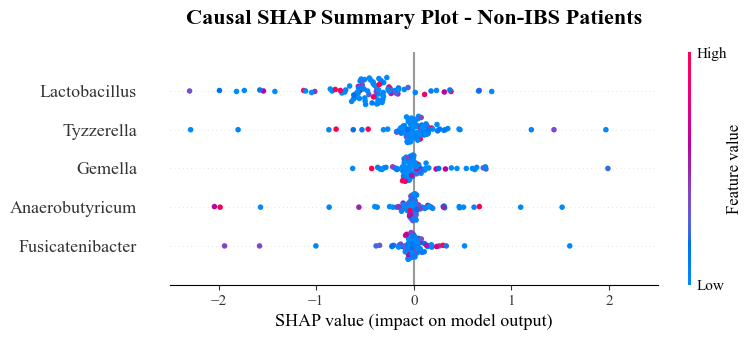

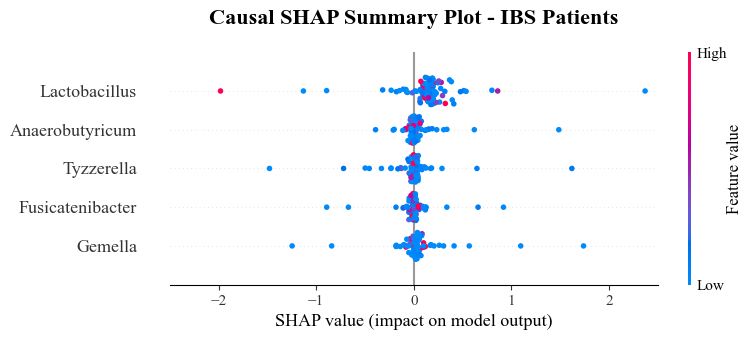

In [29]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First, let's compute Causal SHAP values for more instances to get better visualizations
def compute_causal_shap_matrix(indices, ci, n_samples=50, is_classifier=True):
    """
    Compute Causal SHAP values for multiple instances.
    Returns a matrix compatible with SHAP plotting functions.
    """
    selected_indices = np.random.choice(indices, min(n_samples, len(indices)), replace=False)
    all_shap_values = []
    feature_names = None
    selected_data = []
    
    print(f"Computing Causal SHAP values for {len(selected_indices)} instances...")
    
    for idx in selected_indices:
        instance = X_train.loc[idx]
        shap_scores = ci.compute_modified_shap_proba(instance, is_classifier=is_classifier)
        
        # Get feature names from first instance
        if feature_names is None:
            feature_names = list(shap_scores.keys())
        
        # Convert to list in consistent order
        shap_values_list = [shap_scores[feature] for feature in feature_names]
        all_shap_values.append(shap_values_list)
        selected_data.append(instance)
    
    # Convert to DataFrame with proper feature names
    selected_data_df = pd.DataFrame(selected_data, columns=feature_names)
    
    return np.array(all_shap_values), selected_data_df, feature_names

# Compute Causal SHAP values for both classes
print("\n" + "="*60)
print("Computing Causal SHAP values for visualization...")
print("="*60)

# Get larger samples for better visualizations
n_samples_per_class = 100

# Compute for Non-IBS patients
non_ibs_causal_shap, non_ibs_data, feature_names = compute_causal_shap_matrix(
    non_ibs_indices, ci, n_samples=n_samples_per_class, is_classifier=True
)

# Compute for IBS patients  
ibs_causal_shap, ibs_data, _ = compute_causal_shap_matrix(
    ibs_indices, ci, n_samples=n_samples_per_class, is_classifier=True
)

print(f"Non-IBS Causal SHAP shape: {non_ibs_causal_shap.shape}")
print(f"IBS Causal SHAP shape: {ibs_causal_shap.shape}")
print(f"Feature names: {feature_names}")

# For comparison, let's also compute regular Tree SHAP
print("\nComputing Tree SHAP for comparison...")

# Get the same instances for fair comparison
non_ibs_tree_data = X_train.loc[non_ibs_indices[:n_samples_per_class]]
ibs_tree_data = X_train.loc[ibs_indices[:n_samples_per_class]]

explainer = shap.TreeExplainer(model)
non_ibs_tree_shap = explainer.shap_values(non_ibs_tree_data)
ibs_tree_shap = explainer.shap_values(ibs_tree_data)

# If it's a classifier, tree_shap_values might be a list (one array per class)
if isinstance(non_ibs_tree_shap, list):
    non_ibs_tree_shap = non_ibs_tree_shap[1]  # Use values for positive class (IBS)
    ibs_tree_shap = ibs_tree_shap[1]

print(f"Non-IBS Tree SHAP shape: {non_ibs_tree_shap.shape}")
print(f"IBS Tree SHAP shape: {ibs_tree_shap.shape}")

# 1. SHAP Summary Plot for Non-IBS patients (Causal SHAP)
print("\n" + "="*60)
print("Creating SHAP Summary Plots...")
print("="*60)

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 8))
shap.summary_plot(non_ibs_causal_shap, non_ibs_data, 
                  feature_names=feature_names, show=False, max_display=5)
plt.title("Causal SHAP Summary Plot - Non-IBS Patients", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.xlim(-2.5, 2.5)
plt.show()

# 2. SHAP Summary Plot for IBS patients (Causal SHAP)
plt.figure(figsize=(12, 8))
shap.summary_plot(ibs_causal_shap, ibs_data, 
                  feature_names=feature_names, show=False, max_display=5)
plt.title("Causal SHAP Summary Plot - IBS Patients", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.xlim(-2.5, 2.5)
plt.show()


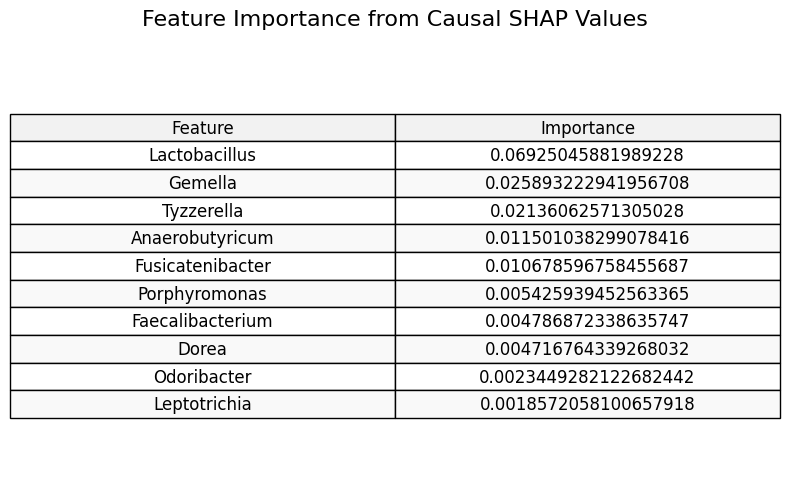

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Feature Importance from Causal SHAP Values'}>)

In [25]:
from visualization import plot_importance_table

plot_importance_table(global_importance, top_n=10, figsize=(8, 5))

## Graph Drawing
recommended_features <- c("Lactobacillus", "Gemella", "Dorea", "Anaerobutyricum", "Coprococcus", "Fusicatenibacter", "Faecalibacterium", "Odoribacter")